In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
import re
import os
from parsedData import parsedData as data

df = pd.DataFrame(data, columns=['Date', 'Time', 'Author', 'Message', 'Conversation'])
df = df.drop('Conversation', axis=1)
df['Word Count'] = df['Message'].apply(lambda s : len(s.split(' ')))
df['Datetime'] = df['Date'] +' '+ df['Time']
# df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=True, format='mixed') 
df['Datetime'] = pd.to_datetime(df['Datetime'], yearfirst=True, format='mixed') 
df= df.drop(['Date','Time'], axis=1)
df = df.sort_values(['Datetime'])
df = df[[df.columns[-1], *df.columns[:-1]]]
        # For custom weighting, we'll create a new column with time in days
        # This makes it easier to calculate weights
base_date = df.Datetime.min()
df['days'] = (df.Datetime - base_date).dt.total_seconds() / (24*3600)
# df = df.set_index('Datetime')
df

,Datetime,Author,Message,Word Count,days
0,2022-05-04 10:47:00,Angelita 🦧,No me has esperado?,5,0.000000
1,2022-05-04 10:58:00,You,Si :(,3,0.007639
2,2022-05-04 10:58:00,You,Pensé que querías subir también,6,0.007639
3,2022-05-04 11:00:00,Angelita 🦧,Te dije espérame,4,0.009028
4,2022-05-04 11:00:00,Angelita 🦧,:(,2,0.009028
...,...,...,...,...,...
214060,2025-04-18 06:55:00,Angelita 🦧,Amooor,2,1079.838889
214061,2025-04-18 06:55:00,Angelita 🦧,La gata,3,1079.838889
214064,2025-04-18 06:55:00,Angelita 🦧,Ups,2,1079.838889
214065,2025-04-18 07:01:00,You,En serioooo,3,1079.843056


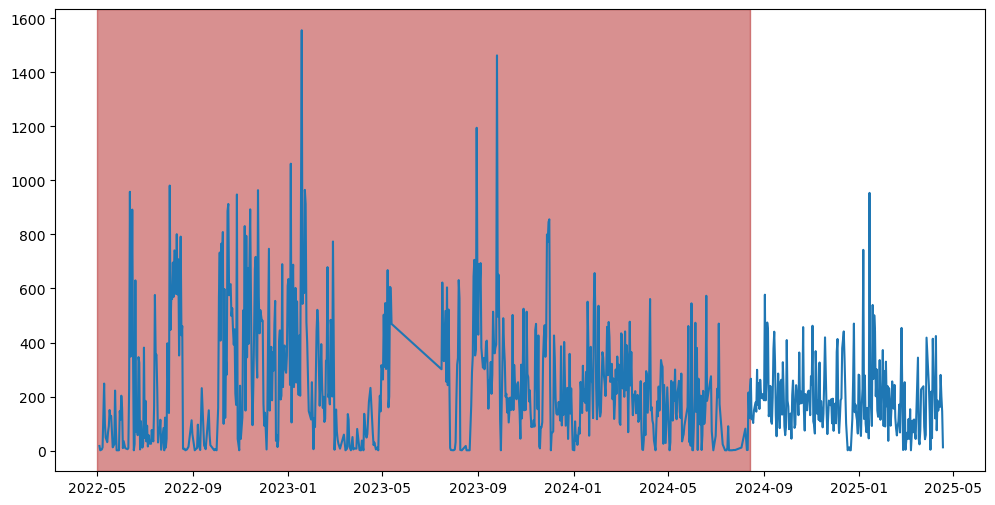

In [10]:
df_days = df.Datetime.dt.floor('d').value_counts()
df_days = df_days.sort_index()
df_days

plt.figure(figsize=(12,6))
plt.plot(df_days)
plt.axvspan(pd.to_datetime('2022-05-01 12:00'), pd.to_datetime('2024-08-13 15:00'), color='firebrick',alpha=0.5)
# plt.axvline(pd.to_datetime('2024-08-13 15:00'),c='firebrick')
# plt.axvline(pd.to_datetime('2024-12-13 10:00'),c='red')
# plt.axvline(pd.to_datetime('2024-12-23 21:00'),c='red')
# plt.axvline(pd.to_datetime('2025-02-24 21:00'),c='red')
# plt.axvline(pd.to_datetime('2025-04-03 07:00'),c='red')

### Region of Interest
<p>The "region of interest" for today is going to be the time period when I was in the Pacific time zone and Angela was in the Central Europe time zone</p>
Which will be from:
<ul> '2024-08-13 15:00' - present</ul>
<ul>'2024-12-13 10:00' - '2024-12-23 21:00'</ul>
<ul>'2025-02-24 21:00' - '2025-04-03 07:00'</ul>


In [12]:
df = df[df.Datetime > '2024-08-13 15:00']

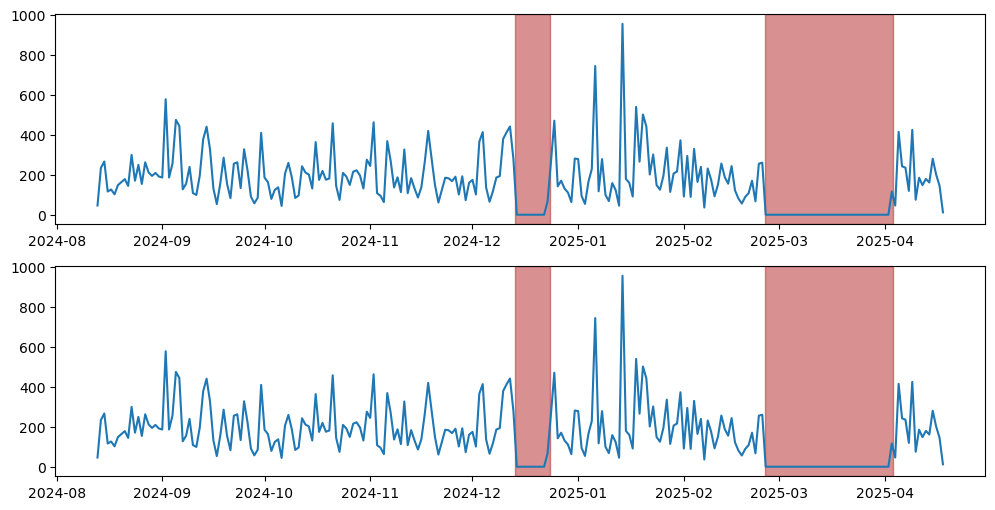

In [116]:
# Count the number of messages per day
df_days = df.Datetime.dt.floor('d').value_counts()
df_days = df_days.sort_index()
df_days = df_days.reindex(pd.date_range(df_days.index[0], df_days.index[-1]), fill_value=0)

# plt.figure(
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(12,6))
ax0.plot(df_days)
ax0.axvspan(pd.to_datetime('2024-12-13 10:00'), pd.to_datetime('2024-12-23 21:00'), color='firebrick',alpha=0.5)
ax0.axvspan(pd.to_datetime('2025-02-24 21:00'), pd.to_datetime('2025-04-03 07:00'), color='firebrick',alpha=0.5)

df = df[(df.Datetime < '2024-12-13 10:00') | (df.Datetime > '2024-12-23 21:00')] 
df = df[(df.Datetime < '2025-02-24 21:00') | (df.Datetime > '2025-04-03 07:00')] 
df_days = df.Datetime.dt.floor('d').value_counts()
df_days = df_days.sort_index()
df_days = df_days.reindex(pd.date_range(df_days.index[0], df_days.index[-1]), fill_value=0)

ax1.plot(df_days)
ax1.axvspan(pd.to_datetime('2024-12-13 10:00'), pd.to_datetime('2024-12-23 21:00'), color='firebrick',alpha=0.5)
ax1.axvspan(pd.to_datetime('2025-02-24 21:00'), pd.to_datetime('2025-04-03 07:00'), color='firebrick',alpha=0.5)

plt.show()

### I should make different dataframes, sorting on different time resolutions ie. Day, Hour, Weekday?
 Dataframe sorting on:
<ul>Day </ul>
<ul> Weekday </ul>
<ul> Hour </ul>

In [117]:
df_days = df_days.to_frame().rename(columns={'count':'Messages'})
df = df.set_index('Datetime')
df_days = df_days.merge(df['Word Count'].resample('d').sum(), left_index=True, right_index=True)
df = df.reset_index()
df_days['WPM'] = df_days['Word Count']/df_days['Messages']
df_days = df_days.reset_index().rename(columns={'index':'Datetime'})
df_days

,Messages,Word Count,WPM
2024-08-13,46,202,4.391304
2024-08-14,234,1161,4.961538
2024-08-15,266,1248,4.691729
2024-08-16,116,609,5.250000
2024-08-17,126,478,3.793651
...,...,...,...
2025-04-14,161,955,5.931677
2025-04-15,280,2191,7.825000
2025-04-16,201,994,4.945274
2025-04-17,145,689,4.751724


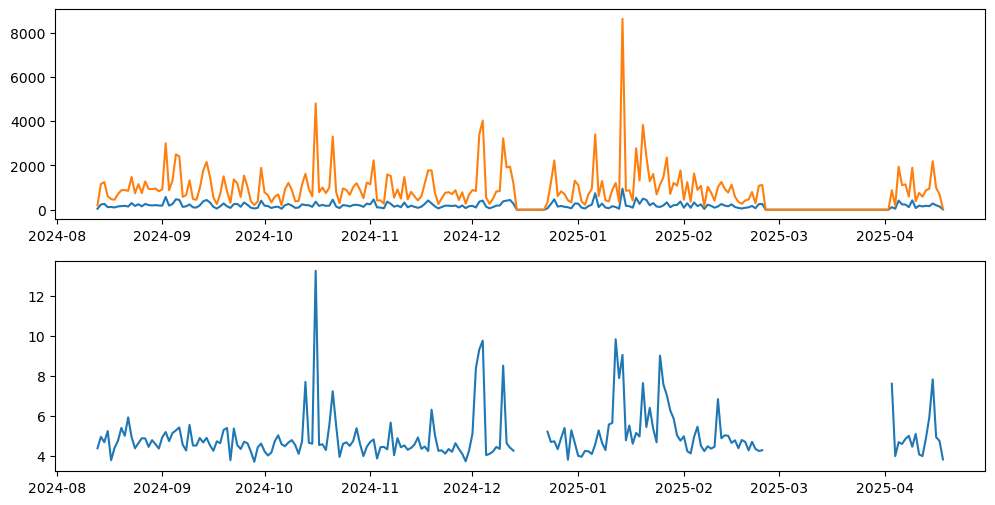

In [118]:

fig, (ax0, ax1)= plt.subplots(2,1,figsize=(12,6))
ax0.plot(df_days['Messages'])
ax0.plot(df_days['Word Count'])
ax1.plot(df_days['Word Count']/df_days['Messages'])


# Average number of Messages sent at different times of day from Miles' perspective

In [202]:
df_hours = df.Datetime.dt.floor('h').value_counts()


df_hours = df_hours.to_frame().rename(columns={'count':'Messages'})

df = df.set_index('Datetime')
df_hours = df_hours.merge(df['Word Count'].resample('h').sum(), left_index=True, right_index=True)
df = df.reset_index()

df_hours['WPM'] = df_hours['Word Count']/df_hours['Messages']
df_hours.sort_index(inplace=True)

df_hours.sort_index(inplace=True)
df_hours = df_hours.reindex(pd.date_range(df_hours.index[0], df_hours.index[-1], freq='h'), fill_value=0)

df_hours = df_hours.reset_index().rename(columns={'index':'Datetime'})
df_hours

,Datetime,Messages,Word Count,WPM
0,2024-08-13 16:00:00,24,118,4.916667
1,2024-08-13 17:00:00,13,48,3.692308
2,2024-08-13 18:00:00,5,21,4.200000
3,2024-08-13 19:00:00,0,0,0.000000
4,2024-08-13 20:00:00,0,0,0.000000
...,...,...,...,...
5939,2025-04-18 03:00:00,2,10,5.000000
5940,2025-04-18 04:00:00,1,5,5.000000
5941,2025-04-18 05:00:00,0,0,0.000000
5942,2025-04-18 06:00:00,7,26,3.714286


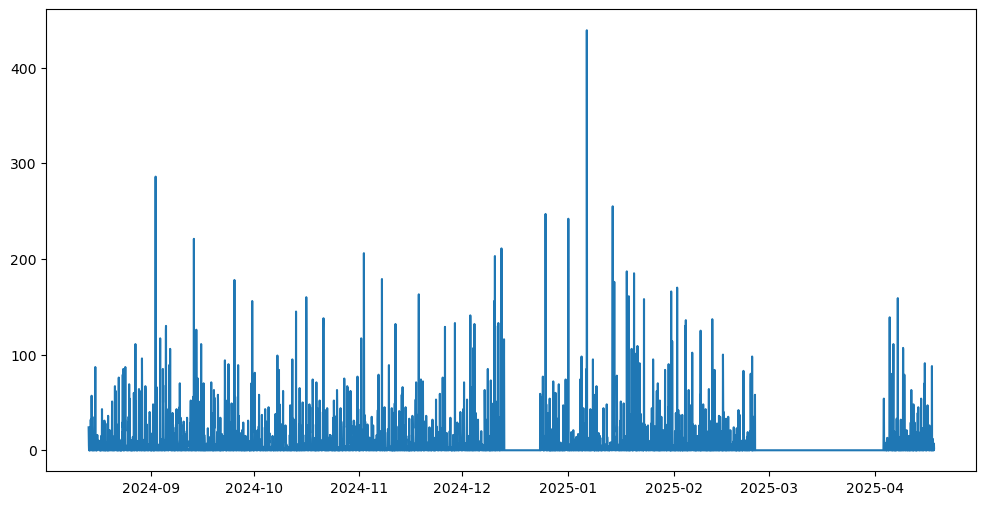

In [183]:
plt.figure(figsize=(12,6))
plt.plot(df_hours.Messages)
plt.show()

In [184]:
wpm.mean()

np.float64(5.4853430301106885)

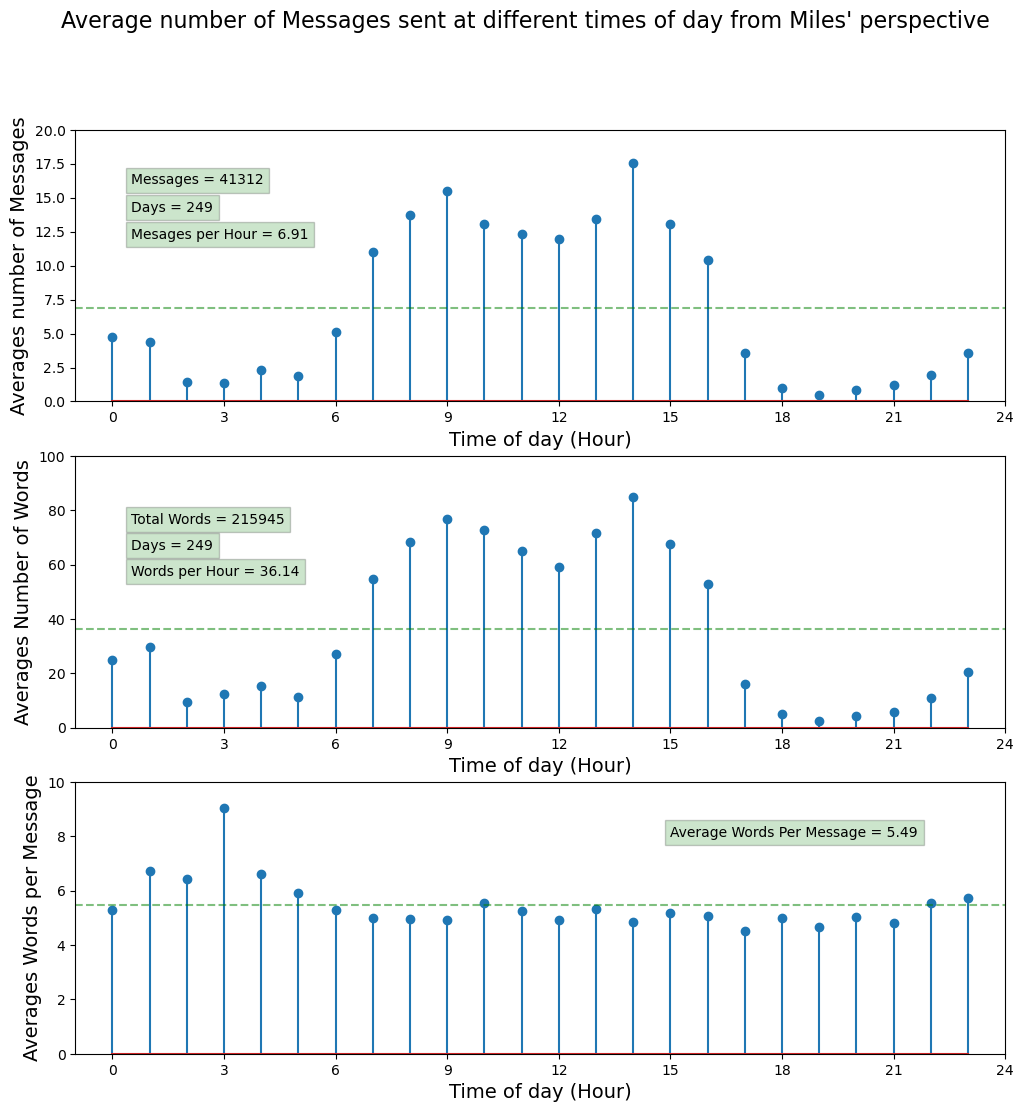

In [203]:
# df_hours = df_hours.reset_index()
# temp = df_hours.Datetime.dt.floor('h').dt.time.value_counts().sort_index()
# temp = grouped_by_hour.agg({'Word Count' : 'sum'})

df_hours.set_index('Datetime', inplace=True)

fig, (ax0, ax1, ax2) = plt.subplots(3,1,figsize=(12,12))
fig.suptitle('Average number of Messages sent at different times of day from Miles\' perspective', fontsize=16)

category, category_label = 'Messages', 'Messages'
ax0.stem(grouped_by_hour.agg({category : 'sum'})[category]/len(df_days))
ax0.text(.5, 16, category_label + f' = {grouped_by_hour.agg({category : 'sum'})[category].sum()}', bbox=dict(facecolor='green', alpha=0.2))
ax0.text(.5, 14, 'Days' + f' = {len(df_days)}', bbox=dict(facecolor='green', alpha=0.2))
ax0.text(.5, 12, 'Mesages per Hour' + f' = {(grouped_by_hour.agg({category : 'sum'})[category].sum()/(24*len(df_days))).round(2)}', bbox=dict(facecolor='green', alpha=0.2))
# ax0.text(.5, 16, f'Total Words = {df_days['Word Count'].sum()}', bbox=dict(facecolor='green', alpha=0.2))
ax0.set_ylabel('Averages number of Messages', fontsize=14)
ax0.set_xlabel('Time of day (Hour)', fontsize=14)
ax0.set_ylim(0,20)
ax0.set_xlim(-1,24)
ax0.set_xticks([0,3,6,9,12,15,18,21,24])
ax0.axhline((grouped_by_hour.agg({category : 'sum'})[category].sum()/(24*len(df_days))).round(2), color='green',alpha=0.5,linestyle='--')

category, category_label = 'Word Count', 'Total Words'
ax1.stem(grouped_by_hour.agg({category : 'sum'})[category]/len(df_days))
ax1.text(.5, 75, category_label + f' = {grouped_by_hour.agg({category : 'sum'})[category].sum()}', bbox=dict(facecolor='green', alpha=0.2))
ax1.text(.5, 65.5, 'Days' + f' = {len(df_days)}', bbox=dict(facecolor='green', alpha=0.2))
ax1.text(.5, 56, 'Words per Hour' + f' = {(grouped_by_hour.agg({category : 'sum'})[category].sum()/(24*len(df_days))).round(2)}', bbox=dict(facecolor='green', alpha=0.2))
# ax0.text(.5, 16, f'Total Words = {df_days['Word Count'].sum()}', bbox=dict(facecolor='green', alpha=0.2))
ax1.set_ylabel('Averages Number of Words', fontsize=14)
ax1.set_xlabel('Time of day (Hour)', fontsize=14)
ax1.set_ylim(0,100)
ax1.set_xlim(-1,24)
ax1.set_xticks([0,3,6,9,12,15,18,21,24])
ax1.axhline((grouped_by_hour.agg({category : 'sum'})[category].sum()/(24*len(df_days))).round(2), color='green',alpha=0.5,linestyle='--')

wpm = (grouped_by_hour.agg({'Word Count' : 'sum'})['Word Count']/grouped_by_hour.agg({'Messages' : 'sum'})['Messages']) # No need to divide by total number of days right?
category, category_label = 'WPM', 'Average Words Per Message'
ax2.stem(wpm)
ax2.text(15, 8, category_label + f' = {(wpm.mean()).round(2)}', bbox=dict(facecolor='green', alpha=0.2))
# ax0.text(.5, 16, f'Total Words = {df_days['Word Count'].sum()}', bbox=dict(facecolor='green', alpha=0.2))
ax2.set_ylabel('Averages Words per Message', fontsize=14)
ax2.set_xlabel('Time of day (Hour)', fontsize=14)
ax2.set_ylim(0,10)
ax2.set_xlim(-1,24)
ax2.set_xticks([0,3,6,9,12,15,18,21,24])
ax2.axhline((wpm.mean().round(2)), color='green',alpha=0.5,linestyle='--')

df_hours.reset_index(inplace=True)
# df_hours.set_index('Datetime', inplace=True)
# plt.show()

# Creating a cool graph inspired by a spike waveforms, using an exponential opacity function, and a cumulative average to converge to the mean

In [392]:
df_hours.Datetime.dt.hour # THis will help me pad the array to to statr at midnight on the first day and end on midnight on the last day

0       16
1       17
2       18
3       19
4       20
        ..
5939     3
5940     4
5941     5
5942     6
5943     7
Name: Datetime, Length: 5944, dtype: int32

In [395]:
temp1 = np.concat((np.full(16, 0), df_hours.Messages.to_numpy(),  np.full(16, 0)))

In [396]:
temp1.reshape(249,24)[:50]

array([[0, 0, 0, ..., 4, 0, 0],
       [5, 0, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 3, 0],
       ...,
       [3, 0, 0, ..., 0, 2, 5],
       [0, 0, 0, ..., 0, 2, 0],
       [6, 4, 0, ..., 0, 0, 2]], shape=(50, 24))

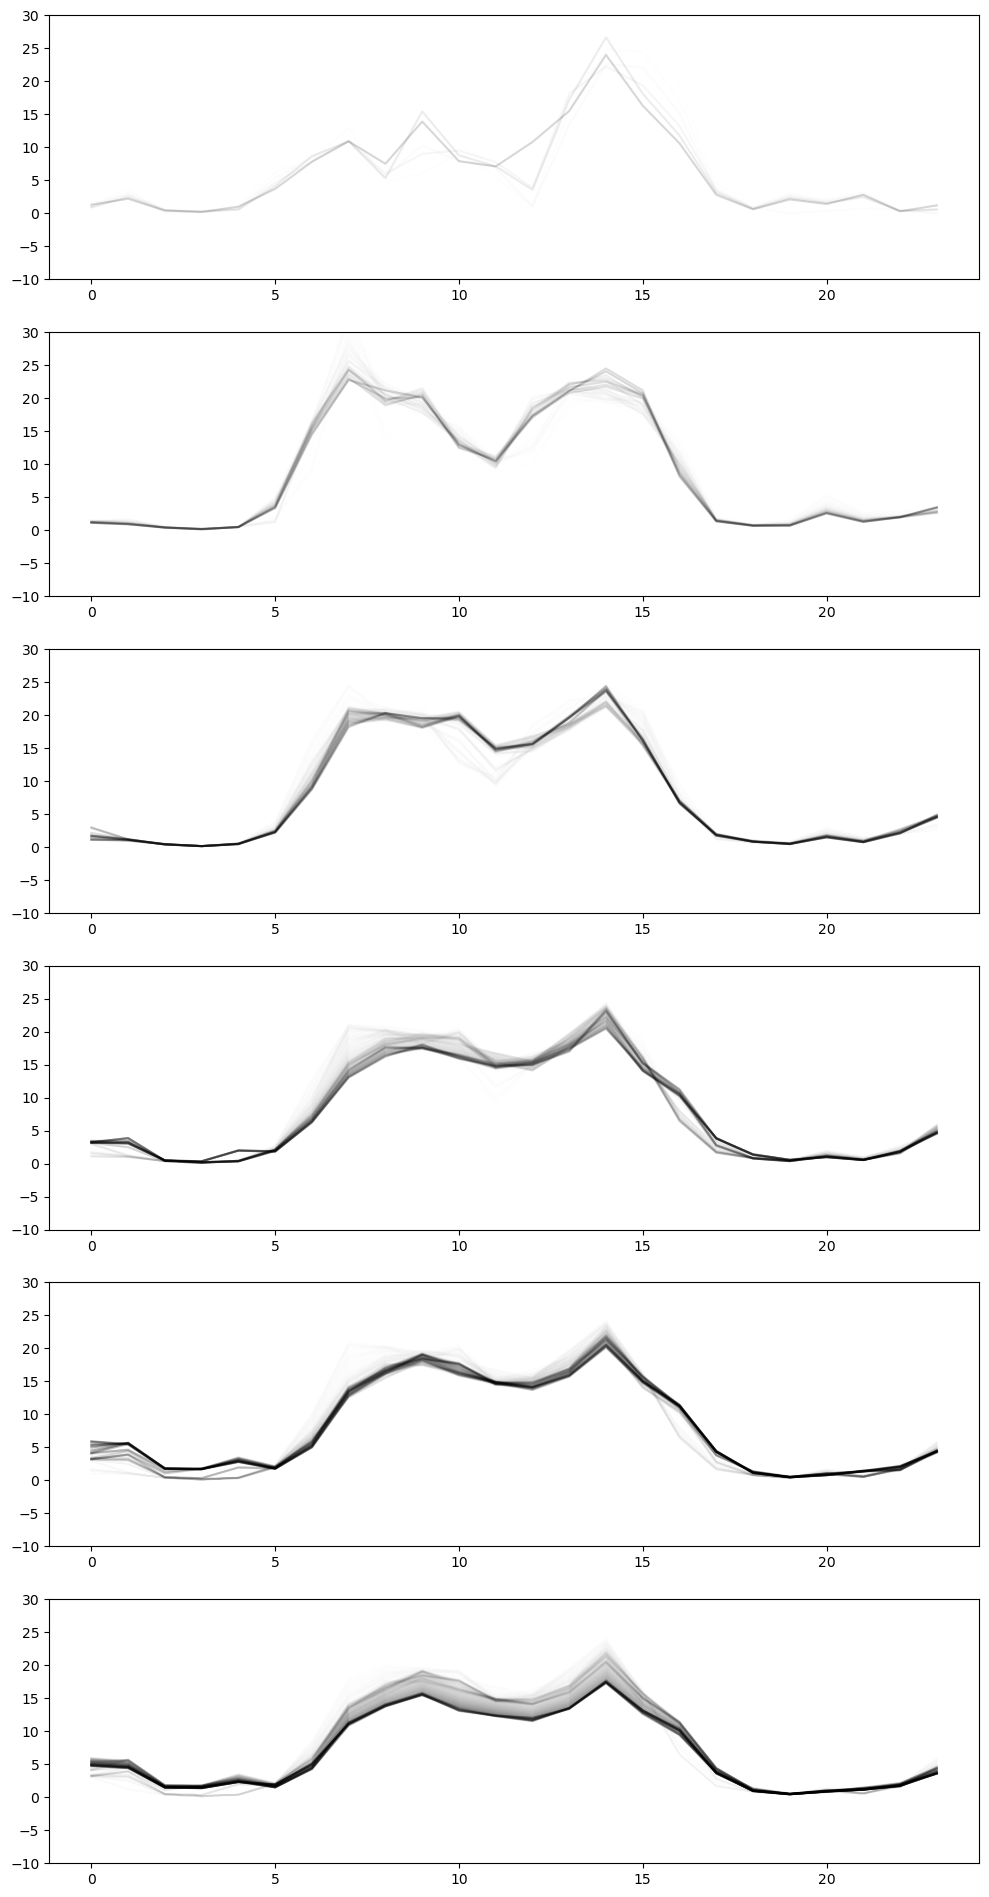

In [397]:

plots=[10,50,100,150,200,249]
fig, ax = plt.subplots(len(plots),figsize=(12,24))
for plot_num,j in enumerate(plots):
    i=0
    l = np.zeros(24)
    # j=100
    for k in temp1.reshape(249,24)[:j]:
        # if max(k) < 20:
        i=i+1
        ax[plot_num].plot(np.arange(24), (k+l)/i, color='black', alpha=10000**((0.8*i/j)-1))
        l += k.copy()
    # plt.plot(temp2[:24], temp1.reshape(249,24)[0])
    # plt.plot(temp2[:24], temp1.reshape(249,24)[1])
    # ax[plot_num].plot(temp1.reshape(249,24).mean(axis=0), color='black',alpha=0.5)
    ax[plot_num].set_ylim(-10,30)
    # ax[plot_num].text(0, 25, 'n' + f' = {j}', bbox=dict(facecolor='green', alpha=0.2))


    
# plt.show()


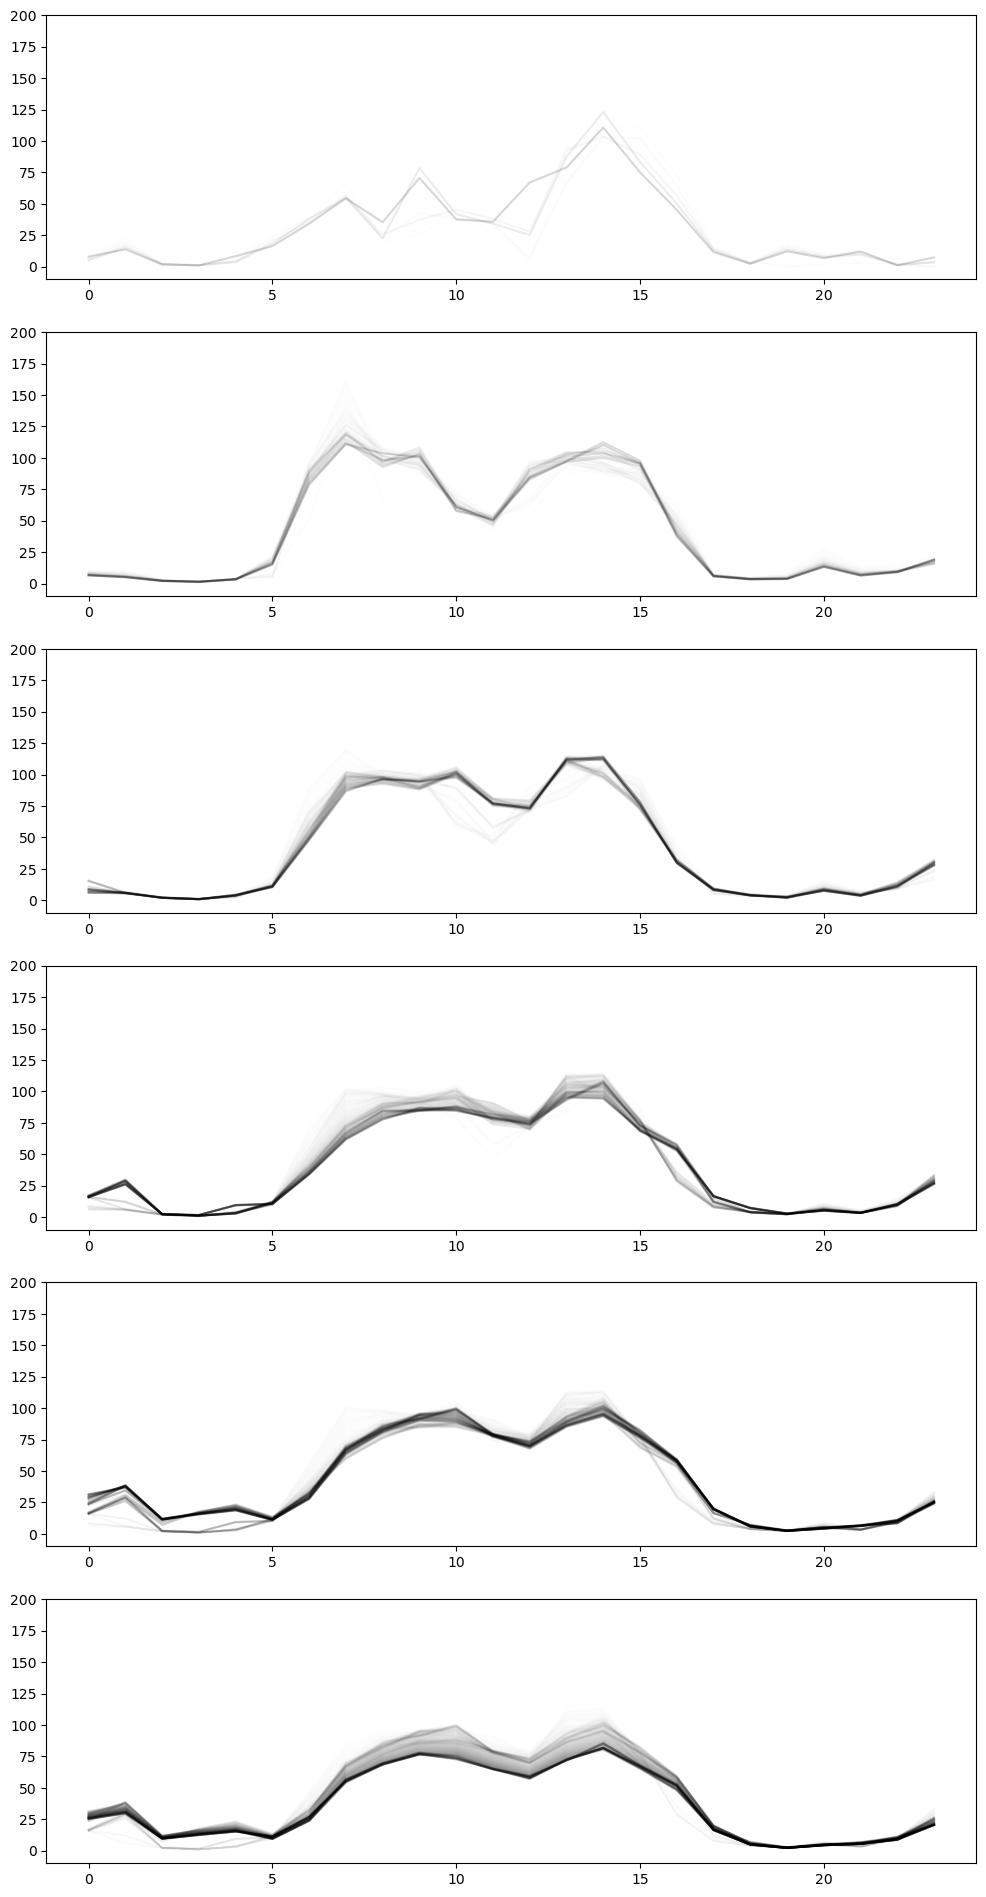

In [400]:
temp1 = np.concat((np.full(16, 0), df_hours['Word Count'].to_numpy(),  np.full(16, 0)))

plots=[10,50,100,150,200,249]
fig, ax = plt.subplots(len(plots),figsize=(12,24))
for plot_num,j in enumerate(plots):
    i=0
    l = np.zeros(24)
    # j=100
    for k in temp1.reshape(249,24)[:j]:
        # if max(k) < 20:
        i=i+1
        ax[plot_num].plot(np.arange(24), (k+l)/i, color='black', alpha=10000**((0.8*i/j)-1))
        l += k.copy()
    # plt.plot(temp2[:24], temp1.reshape(249,24)[0])
    # plt.plot(temp2[:24], temp1.reshape(249,24)[1])
    # ax[plot_num].plot(temp1.reshape(249,24).mean(axis=0), color='black',alpha=0.5)
    ax[plot_num].set_ylim(-10,200)
    # ax[plot_num].text(0, 25, 'n' + f' = {j}', bbox=dict(facecolor='green', alpha=0.2))


    
plt.show()

In [355]:
df_hours.Messages.to_numpy()

array([24, 13,  5, ...,  0,  7,  2], shape=(5944,))

In [ ]:
temp1 = np.concat((np.full(16, np.nan), df_hours.Messages.to_numpy(),  np.full(16, np.nan)))

# Same as above but using weekly averages instead!

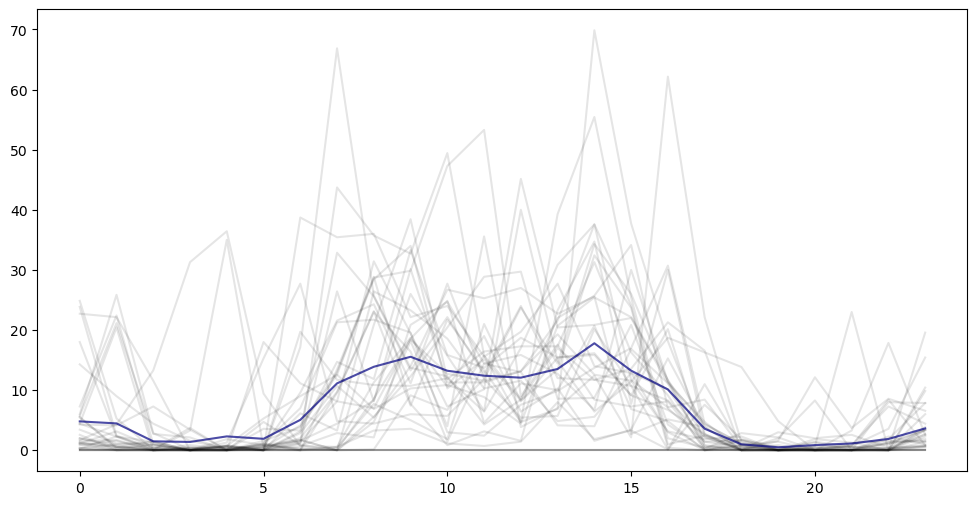

In [380]:
temp1 = np.concat((np.full(16, np.nan), df_hours.Messages.to_numpy(),  np.full(16, np.nan)))
test = temp1.reshape(249,24)[1:246]
test = test.reshape(35,7,24).mean(axis=1)

plt.figure(figsize=(12,6))
for k in test:
    plt.plot(k,c='black',alpha=0.1)
plt.plot(test.mean(axis=0),c='navy',alpha=0.7)
plt.show()

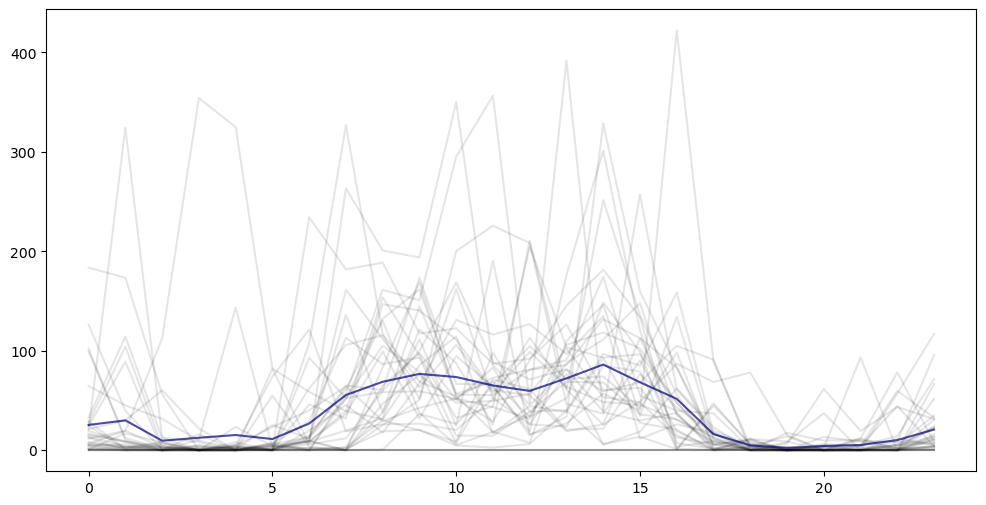

In [402]:
temp1 = np.concat((np.full(16, np.nan), df_hours['Word Count'].to_numpy(),  np.full(16, np.nan)))
test = temp1.reshape(249,24)[1:246]
test = test.reshape(35,7,24).mean(axis=1)

plt.figure(figsize=(12,6))
for k in test:
    plt.plot(k,c='black',alpha=0.1)
plt.plot(test.mean(axis=0),c='navy',alpha=0.7)
plt.show()

# Well none of the daily averages are looking super good... Maybe I'll have better luck with the weekly plots?

In [422]:
df_days.Messages

0       46
1      234
2      266
3      116
4      126
      ... 
244    161
245    280
246    201
247    145
248     12
Name: Messages, Length: 249, dtype: int64

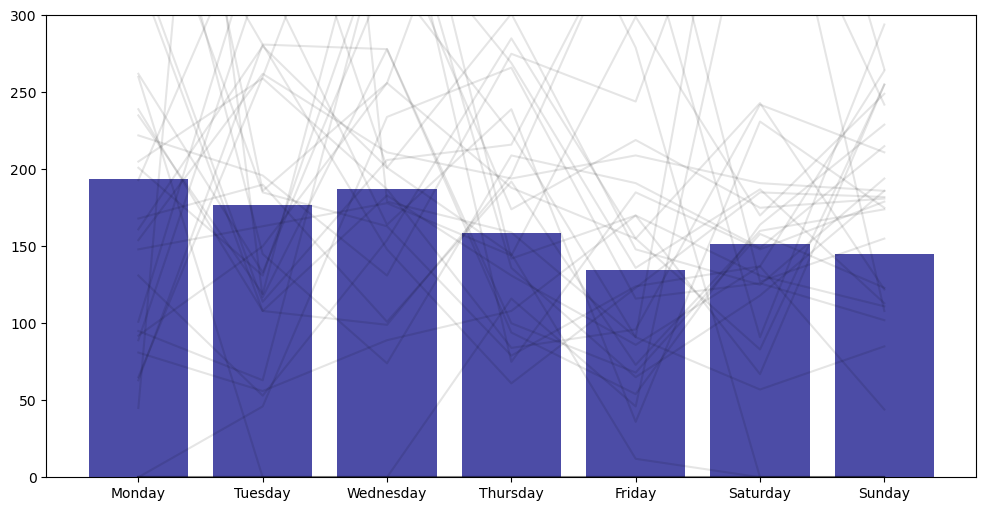

In [430]:
temp1 = np.concatenate((np.array([0]), df_days.Messages, np.array([0,0]))).reshape(36,7)
test = temp1
test = test.mean(axis=0)

plt.figure(figsize=(12,6))
for k in temp1:
    plt.plot(k,c='black',alpha=0.1)
plt.bar(np.array(['Monday','Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']),test,color='navy',alpha=0.7)
plt.ylim(0,300)
plt.show()

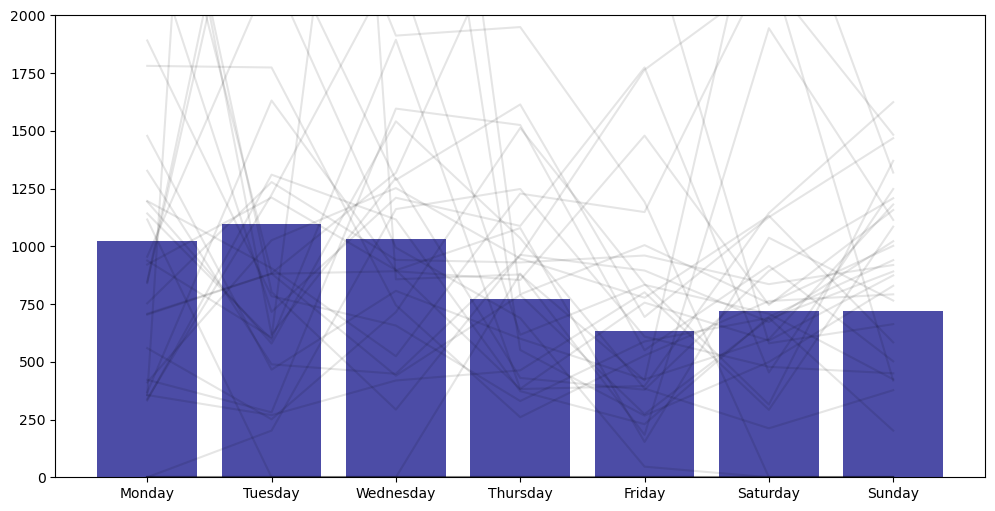

In [434]:
temp1 = np.concatenate((np.array([0]), df_days['Word Count'], np.array([0,0]))).reshape(36,7)
test = temp1
test = test.mean(axis=0)

plt.figure(figsize=(12,6))
for k in temp1:
    plt.plot(k,c='black',alpha=0.1)
plt.bar(np.array(['Monday','Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']),test,color='navy',alpha=0.7)
plt.ylim(0,2000)
plt.show()